In [1]:
import pandas as pd
import numpy as np
import json

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import sys
import os
sys.path.append(os.path.abspath('../'))
from tool import *

import matplotlib.pyplot as plt


data_root = '../../MyData/'

# New load data

In [2]:
train_data = torch.load("../5_synthetic_data_generation/data/train_data.pth")
train_label = torch.load("../5_synthetic_data_generation/data/train_label.pth")
test_data = torch.load("../5_synthetic_data_generation/data/test_data.pth")
test_label = torch.arange(1197)

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

torch.Size([34683, 256])
torch.Size([34683])
torch.Size([1197, 256])
torch.Size([1197])


In [3]:
# Get cik
new_embedding_df = pd.read_csv("./data/embedding_256.csv")

unique_cik = new_embedding_df['cik'].unique()
cik_to_index = {cik: idx for idx, cik in enumerate(unique_cik)}
index_to_cik = {idx: cik for idx, cik in enumerate(unique_cik)}
print("CIK to Index Mapping:", cik_to_index)

CIK to Index Mapping: {850460: 0, 352541: 1, 1704715: 2, 1575515: 3, 1125376: 4, 1674335: 5, 1023128: 6, 1262039: 7, 1122976: 8, 1128928: 9, 58492: 10, 40533: 11, 1370946: 12, 1469367: 13, 858655: 14, 1486159: 15, 70145: 16, 77476: 17, 1593034: 18, 1140536: 19, 1353283: 20, 912728: 21, 73309: 22, 1754301: 23, 882796: 24, 1309402: 25, 1524358: 26, 80424: 27, 1551182: 28, 1283699: 29, 1158172: 30, 8947: 31, 804328: 32, 1120370: 33, 1655075: 34, 1361658: 35, 40987: 36, 1320414: 37, 1584509: 38, 1466301: 39, 1552033: 40, 1281761: 41, 93410: 42, 76282: 43, 19584: 44, 723531: 45, 1530804: 46, 101984: 47, 910329: 48, 5513: 49, 31462: 50, 1338749: 51, 1409171: 52, 821026: 53, 817720: 54, 5272: 55, 1013871: 56, 1111928: 57, 1393818: 58, 66382: 59, 812011: 60, 730708: 61, 1672013: 62, 1109242: 63, 883945: 64, 1527166: 65, 1421461: 66, 355811: 67, 1262823: 68, 26058: 69, 14930: 70, 1637459: 71, 892553: 72, 1345016: 73, 844965: 74, 1318220: 75, 819793: 76, 1175454: 77, 936468: 78, 29989: 79, 35291

In [4]:
dissimilar_df = pd.read_csv(data_root + "dissimilar_pairs_2021.csv")
print(f"length of dissimilar_df: {len(dissimilar_df)}")
print(f"dissimilar_df columns: {dissimilar_df.columns}")
company_a_cik_set = set(dissimilar_df['company_a_cik'].unique())
company_b_cik_set = set(dissimilar_df['company_b_cik'].unique())
dissimilar_union_set = company_a_cik_set.union(company_b_cik_set)
print(f"number of firms occured in dissimilar_df: {len(dissimilar_union_set)} \n")

similar_df = pd.read_csv(data_root + "pairs_gpt_competitors_2021.csv")
print(f"length of similar_df: {len(similar_df)}")
print(f"similar_df columns: {similar_df.columns}")
company_a_cik_set = set(similar_df['company_a_cik'].unique())
company_b_cik_set = set(similar_df['company_b_cik'].unique())
similar_union_set = company_a_cik_set.union(company_b_cik_set)
print(f"number of firms occured in similar_df: {len(similar_union_set)} \n")

print(f"final union set length: {len(dissimilar_union_set.union(similar_union_set))}")

# similar_df = similar_df[['company_a_cik', 'company_b_cik']]
# dissimilar_df = dissimilar_df[['company_a_cik', 'company_b_cik']]

length of dissimilar_df: 2913
dissimilar_df columns: Index(['Unnamed: 0', 'company_a_name', 'company_a_cik', 'company_a_products',
       'company_b_cik', 'company_b_name', 'company_b_tic',
       'company_b_products', 'reason_for_dissimilarity'],
      dtype='object')
number of firms occured in dissimilar_df: 1196 

length of similar_df: 2365
similar_df columns: Index(['Unnamed: 0', 'company_a_name', 'company_a_cik', 'company_b_cik',
       'company_b_name', 'company_b_tic', 'competing_products'],
      dtype='object')
number of firms occured in similar_df: 1110 

final union set length: 1197


In [13]:
exp_df = pd.read_csv("./data/embedding_256.csv")[['cik', 'tic', 'Year']]
print(len(exp_df))
exp_df.head()

1197


,cik,tic,Year
0,850460,WIRE,2021
1,352541,LNT,2021
2,1704715,AMR,2021
3,1575515,SFM,2021
4,1125376,ENSG,2021


# Create dataset

### Prepare labels

In [5]:
# Get number of unique entities
N = len(unique_cik)

# Initialize the relation matrix with -1 (unknown/no relation)
relation_matrix = -1 * np.ones((N, N))

# Fill in similar pairs
for _, row in similar_df.iterrows():
    i, j = cik_to_index[row['company_a_cik']], cik_to_index[row['company_b_cik']]
    relation_matrix[i, j] = 1
    relation_matrix[j, i] = 1  # Ensure symmetry

# Fill in dissimilar pairs
for _, row in dissimilar_df.iterrows():
    i, j = cik_to_index[row['company_a_cik']], cik_to_index[row['company_b_cik']]
    relation_matrix[i, j] = 0
    relation_matrix[j, i] = 0  # Ensure symmetry

# Set diagonal to -1 (self-relations not needed)
np.fill_diagonal(relation_matrix, -1)

# Convert to PyTorch tensor
relation_matrix = torch.tensor(relation_matrix, dtype=torch.float32)

print("Relation Matrix:\n", relation_matrix)


# Count number of 1's
num_ones = (relation_matrix == 1).sum().item()

# Count number of -1's
num_neg_ones = (relation_matrix == 0).sum().item()

print(f"Number of 1's: {num_ones}")
print(f"Number of 0's: {num_neg_ones}")

Relation Matrix:
 tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])
Number of 1's: 4564
Number of 0's: 5826


#### **Some similar pairs are useless!**

In [6]:
# print(len(similar_df))
# print(len(dissimilar_df))
# similar_df[similar_df['company_a_cik'] == similar_df['company_b_cik']]

### Final step

In [7]:
# Define a custom dataset
class ContrastiveDataset(Dataset):
    def __init__(self, data, index_list):
        self.data = data
        self.index_list = index_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.index_list[idx]



train_dataset = ContrastiveDataset(train_data, train_label)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = ContrastiveDataset(test_data, torch.arange(1197))
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

# Model training

In [8]:
class ProjectionNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(ProjectionNet, self).__init__()
        
        # Define the layers sequentially
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),         # First fully connected layer
            nn.BatchNorm1d(hidden_dim),               # Batch Normalization
            nn.LeakyReLU(negative_slope=0.01),        # LeakyReLU activation
            # nn.Dropout(p=dropout_prob),               # Dropout
            nn.Linear(hidden_dim, output_dim)         # Second fully connected layer
        )
    
    def forward(self, x):
        # Pass the input through the sequential model
        return self.model(x)


# Define contrastive loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, z1, z2, labels):
        distances = torch.norm(z1 - z2, p=2, dim=1)
        loss = (labels * distances.pow(2)) + ((1 - labels) * torch.relu(self.margin - distances).pow(2))
        return loss.mean()

In [32]:
input_dim = 256
output_dim = 128


model = ProjectionNet(input_dim, output_dim, 256)
criterion = ContrastiveLoss(margin=5.0)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for batch_data, batch_idx in train_loader:

        batch_size = batch_data.size(0)
        shuffled_indices = torch.randperm(batch_size)

        z1 = model(batch_data)
        z2 = z1[shuffled_indices]
        shuffled_idx = batch_idx[shuffled_indices]
        pair_labels = relation_matrix[batch_idx, shuffled_idx]

        # Filter out neutral pairs (if any)
        mask = pair_labels != -1
        if mask.any():  # Check if there's at least one valid pair
            z1 = z1[mask]
            z2 = z2[mask]
            pair_labels = pair_labels[mask]

            # Compute loss
            loss = criterion(z1, z2, pair_labels)
        else:
            # Use a dummy tensor with requires_grad=True to avoid backward errors
            loss = torch.tensor(0.0, device=z1.device, requires_grad=True)
        
        total_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], train_avg_Loss: {total_loss/len(train_loader):.4f}")

    total_loss = 0
    model.eval()
    with torch.no_grad():
        for batch_data, batch_idx in test_loader:

            batch_size = batch_data.size(0)
            shuffled_indices = torch.randperm(batch_size)

            z1 = model(batch_data)
            z2 = z1[shuffled_indices]
            shuffled_idx = batch_idx[shuffled_indices]
            pair_labels = relation_matrix[batch_idx, shuffled_idx]

            # Filter out neutral pairs (if any)
            mask = pair_labels != -1
            if mask.any():  # Check if there's at least one valid pair
                z1 = z1[mask]
                z2 = z2[mask]
                pair_labels = pair_labels[mask]

                # Compute loss
                loss = criterion(z1, z2, pair_labels)
            else:
                # Use a dummy tensor with requires_grad=True to avoid backward errors
                loss = torch.tensor(0.0, device=z1.device, requires_grad=True)
            
            total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], test_avg_Loss: {total_loss/len(test_loader):.4f}\n")

Epoch [1/20], train_avg_Loss: 4.9494
Epoch [1/20], test_avg_Loss: 3.2025

Epoch [2/20], train_avg_Loss: 3.8925
Epoch [2/20], test_avg_Loss: 4.0210

Epoch [3/20], train_avg_Loss: 3.4533
Epoch [3/20], test_avg_Loss: 1.9644

Epoch [4/20], train_avg_Loss: 3.0371
Epoch [4/20], test_avg_Loss: 1.3431

Epoch [5/20], train_avg_Loss: 2.6800
Epoch [5/20], test_avg_Loss: 1.5752

Epoch [6/20], train_avg_Loss: 2.3588
Epoch [6/20], test_avg_Loss: 1.0957

Epoch [7/20], train_avg_Loss: 2.1356
Epoch [7/20], test_avg_Loss: 1.8209

Epoch [8/20], train_avg_Loss: 2.3930
Epoch [8/20], test_avg_Loss: 1.9726

Epoch [9/20], train_avg_Loss: 1.7807
Epoch [9/20], test_avg_Loss: 1.0812

Epoch [10/20], train_avg_Loss: 2.1264
Epoch [10/20], test_avg_Loss: 1.9521

Epoch [11/20], train_avg_Loss: 1.7550
Epoch [11/20], test_avg_Loss: 1.7718

Epoch [12/20], train_avg_Loss: 1.6953
Epoch [12/20], test_avg_Loss: 1.9899

Epoch [13/20], train_avg_Loss: 1.8404
Epoch [13/20], test_avg_Loss: 1.9738

Epoch [14/20], train_avg_Loss:

In [33]:
model.eval()
with torch.no_grad():
    final_representation = model(test_data)
final_representation.shape

torch.Size([1197, 128])

In [34]:
exp_df['cluster_10'] = cluster(final_representation, 10)
exp_df['cluster_100'] = cluster(final_representation, 100)
exp_df

Normalized Within-Cluster Sum of Squares (WCSS): 0.02304805510225352
Normalized Within-Cluster Sum of Squares (WCSS): 0.01395472826913883


,cik,tic,Year,cluster_10,cluster_100
0,850460,WIRE,2021,1,87
1,352541,LNT,2021,4,2
2,1704715,AMR,2021,4,95
3,1575515,SFM,2021,3,23
4,1125376,ENSG,2021,9,48
...,...,...,...,...,...
1192,1021860,NOV,2021,6,28
1193,1744489,DIS,2021,5,76
1194,1102112,PACW,2021,7,43
1195,28823,DBD,2021,1,5


In [35]:
year = 2021
mode = 'forward'  # Can be 'in-sample', 'forward', or 'backtest'
returns_long = pd.read_csv(data_root+"returns_long.csv")

exp_returns = pd.merge(exp_df, returns_long, on='tic', how='inner')

exp_intra_corrs_10 = intra_industry_correlations(exp_returns, "cluster_10")
exp_avg_intra_corr_10 = np.nanmean(list(exp_intra_corrs_10.values()))
print(exp_avg_intra_corr_10)

exp_intra_corrs_100 = intra_industry_correlations(exp_returns, "cluster_100")
exp_avg_intra_corr_100 = np.nanmean(list(exp_intra_corrs_100.values()))
print(exp_avg_intra_corr_100)

print(len(exp_returns['cik'].unique()))

0.35628254991761615
0.44176612033452073
1064


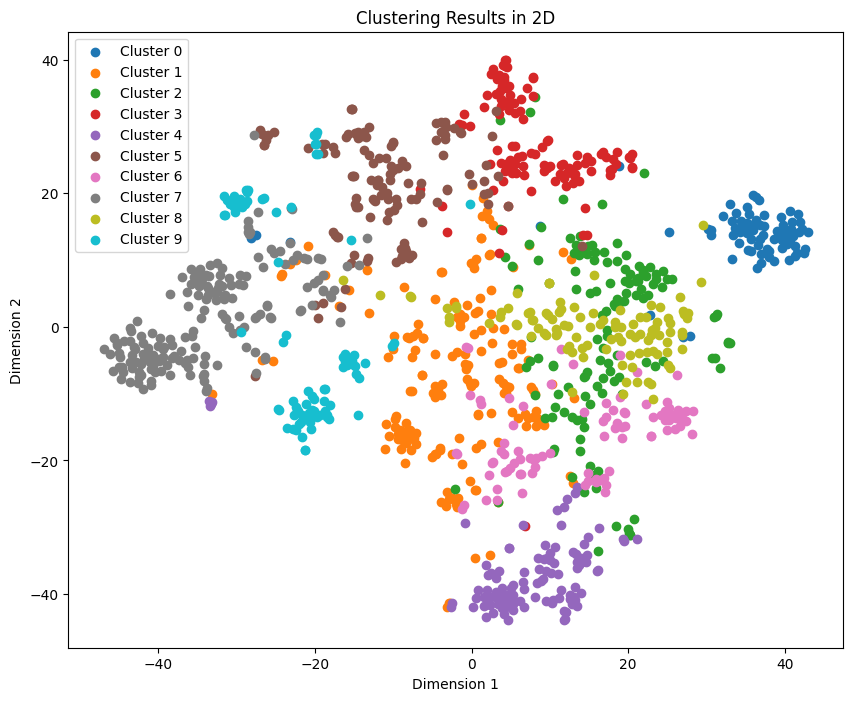

In [36]:
show_cluster_graph(final_representation, exp_df['cluster_10'])

# Pair eval

In [37]:
similar_df = pd.read_csv(data_root + "pairs_gpt_competitors_2021.csv")
similar_df = similar_df[similar_df['company_a_cik'] != similar_df['company_b_cik']]


In [38]:
similar_df_results = precision_and_false_positive(similar_df, exp_df.copy(), ['cluster_10', 'cluster_100'], 10000)
similar_df_results

Missing CIKs in pairs dataset: 0 (company A), 0 (company B)
CIKs not found in main dataset: 0 (company A), 0 (company B)
Total valid pairs: 2282
cluster_10
Original number of positive pairs: 2282
Number of positive pairs after filtering: 2282


cluster_100
Original number of positive pairs: 2282
Number of positive pairs after filtering: 2282




,Classification_Scheme,Precision,False_Positive_rate,N_Industries,Avg_Firms_per_Industry
0,cluster_10,0.763804,0.977211,10,119.70
1,cluster_100,0.580193,0.868429,100,11.97
